# Visualization of Ice Fraction on the Artic

In [1]:
!pip install cmcrameri

In [2]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.animation as animation
import numpy as np
import cmcrameri.cm as cmc
import cftime
import intake
import warnings
warnings.filterwarnings("ignore")

## Open Pangeo CMIP6 catalog

In [3]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,709
grid_label,10
zstore,521429
dcpp_init_year,60


In [4]:
cat = col.search(source_id=['CESM2'], experiment_id=['historical'],  variable_id=['sithick'], member_id=['r1i1p1f1'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r1i1p1f1,SImon,sithick,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308


In [5]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [6]:
list(dset_dict.keys())

['CMIP.NCAR.CESM2.historical.SImon.gn']

In [7]:
dset = dset_dict['CMIP.NCAR.CESM2.historical.SImon.gn']
dset

<xarray.Dataset>
Dimensions:    (nj: 384, ni: 320, nvertices: 4, member_id: 1, time: 1980, d2: 2)
Coordinates:
    lat        (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat_bnds   (nj, ni, nvertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon        (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon_bnds   (nj, ni, nvertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
  * ni         (ni) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * nj         (nj) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, d2) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: nvertices, d2
Data variables:
    sithick    (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 1845, 384, 320), meta=np.ndarray>
Attributes: (12/50)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    674885.0
    branch_time_in_parent:   219000.0
    case_id:                 15
    ...                      ...
    variant_label:           r1i1p1f1
    status:                  2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:     hdl:21.14100/99b38949-02c7-40a2-b950-9434e46adc45
    version_id:              v20190308
    intake_esm_varname:      ['sithick']
    intake_esm_dataset_key:  CMIP.NCAR.CESM2.historical.SImon.gn

In [8]:
dset.coords['lon'] = (dset['lon'] + 180) % 360 - 180

In [9]:
dset.sithick

<xarray.DataArray 'sithick' (member_id: 1, time: 1980, nj: 384, ni: 320)>
dask.array<broadcast_to, shape=(1, 1980, 384, 320), dtype=float32, chunksize=(1, 1845, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    lat        (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon        (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * ni         (ni) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * nj         (nj) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: time: mean where sea_ice (comment: mask=siconc)
    comment:        (in OImon, sit was volume per entire cell area)
    description:    (in OImon, sit was volume per entire cell area)
    frequency:      mon
    id:             sithick
    long_name:      Sea Ice Thickness
    mipTable:       SImon
    out_name:       sithick
    prov:           SIMIP [seaicemon]
    realm:          seaIce ocean
    standard_name:  sea_ice_thickness
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Ice Thickness
    type:           real
    units:          m
    variable_id:    sithick

In [10]:
xr.set_options(keep_attrs=True)

### Visualize Ice fraction for control experiment

In [11]:
#No initialization needed
def init():
    return 

def single_figure(i, dset, var, vmin, vmax):
    dsel = dset.isel(time=i).where(dset.isel(time=i).lat > 50)
    ax=fig.axes[0]
    ax.clear()
    plotcrs = ccrs.Orthographic(central_longitude=10.0, central_latitude=(90))
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_xmargin(0.0)
    ax.set_ymargin(0.0)
    ax.coastlines(resolution='50m')
    ax.gridlines()
    plotcrs = ccrs.Orthographic(central_longitude=10.0, central_latitude=(90))
    map = dsel[var].plot(ax=ax,
                        x="lon", y="lat",
                        vmin=vmin, vmax=vmax,
                        cmap=cmc.oslo_r,
                        add_colorbar=False,
                        transform=ccrs.PlateCarree())

    ax.set_title('CMIP6 CESM2 historical\n' + cftime.DatetimeNoLeap(dsel[var].time.dt.year.values, dsel[var].time.dt.month.values, dsel[var].time.dt.day.values).strftime("%B %Y"), fontsize=15)

    if i==0:
        cbar = fig.colorbar(map, ax=ax, extend='both', orientation='horizontal')
        cbar.ax.tick_params(labelsize=12)
        cbar.ax.set_xlabel(dsel[var].long_name + ' [' + dsel[var].units + ']', fontsize=15)
    return

#### Figure for the first date

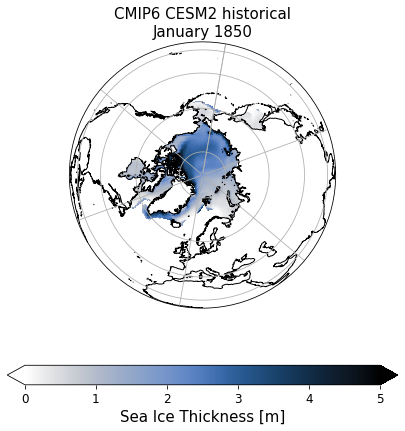

In [12]:
var = 'sithick'
vmin=0
vmax=5

fig = plt.figure(figsize=(7,7))
plotcrs = ccrs.Orthographic(central_longitude=10.0, central_latitude=(90))
ax = plt.subplot(projection=plotcrs)

single_figure(0, dset, var, vmin, vmax)

#### Animation for all the dates of the control experiment

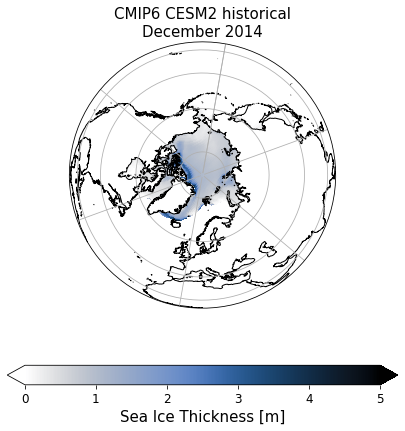

In [13]:
var = 'sithick'
vmin=0
vmax=5
fig = plt.figure(figsize=(7,7))
plotcrs = ccrs.Orthographic(central_longitude=10.0, central_latitude=(90))
ax = plt.subplot(projection=plotcrs)

nframes = 1980  # number of frames per cycle
seconds = 20. # desired duration
interval = seconds/nframes


#Animate it and save!
anim = animation.FuncAnimation(fig, single_figure, init_func=init, 
                               frames=nframes, interval=interval, 
                               fargs=(dset, var, vmin, vmax), blit=False)
anim.save('artic-' + var + '.gif',  fps = 1/interval, writer='pillow')